In [12]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
import random
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")


x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

# del X_train,X_test

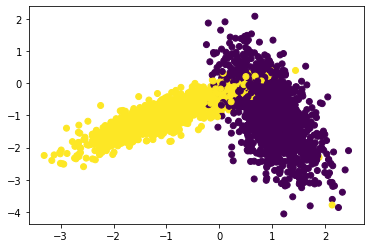

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
colors = {0:'red', 1:'blue'}
plt.scatter(X_test[:,0], X_test[:,1],c=y_test)
plt.show()

# Implementing Custom RandomSearchCV

<pre>
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    # x_train: its numpy array of shape, (n,d)
    # y_train: its numpy array of shape, (n,) or (n,1)
    # classifier: its typically KNeighborsClassifier()
    # param_range: its a tuple like (a,b) a < b
    # folds: an integer, represents number of folds we need to devide the data and test our model
    
    
    #1.generate 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params" 
    # ex: if param_range = (1, 50), we need to generate 10 random numbers in range 1 to 50
    #2.devide numbers ranging from  0 to len(X_train) into groups= folds
    # ex: folds=3, and len(x_train)=100, we can devide numbers from 0 to 100 into 3 groups 
      group 1: 0-33, group 2:34-66, group 3: 67-100
    #3.for each hyperparameter that we generated in step 1:
        # and using the above groups we have created in step 2 you will do cross-validation as follows
        
        # first we will keep group 1+group 2 i.e. 0-66 as train data and group 3: 67-100 as test data, and find train and
          test accuracies
          
        # second we will keep group 1+group 3 i.e. 0-33, 67-100 as train data and group 2: 34-66 as test data, and find
          train and test accuracies
          
        # third we will keep group 2+group 3 i.e. 34-100 as train data and group 1: 0-33 as test data, and find train and
          test accuracies
        # based on the 'folds' value we will do the same procedure
        
        # find the mean of train accuracies of above 3 steps and store in a list "train_scores"
        # find the mean of test accuracies of above 3 steps and store in a list "test_scores"
    #4. return both "train_scores" and "test_scores"

#5. call function RandomSearchCV(x_train,y_train,classifier, param_range, folds) and store the returned values into "train_score", and "cv_scores"
#6. plot hyper-parameter vs accuracy plot as shown in reference notebook and choose the best hyperparameter
#7. plot the decision boundaries for the model initialized with the best hyperparameter, as shown in the last cell of reference notebook

</pre>

In [14]:
#split dataset of len=n in f parts and return indices of each parts
def split_into_folds(n,f):
  
  split_list = [[0,0] for _ in range(f)]

  # not equaly divisible into f parts
  if n%f != 0:
    step = (n-(n%f))//f 
    for i in range(n%f):
      split_list[i][1] = 1

    split_list[0][1] += (step-1)
    for idx in range(1,f):
      split_list[idx][0] = split_list[idx-1][1]+1
      split_list[idx][1] += (split_list[idx][0]+step-1)

  #equaly divisible into f parts :
  else:
    step = n // f 
    for i in range(0,f):
      split_list[i][1] = (step*(i+1))-1

    for i in range(1,f):
      split_list[i][0] += split_list[i-1][1]+1

  # print(split_list)
  # for x in split_list:
  #   print(x[1]-x[0]+1,end=" , ")
  # print()

  return [list(range(x[0],x[1]+1)) for x in split_list]


In [17]:
def RandomSearchCV(xTrain,yTrain,classifier, param_range, folds):
  trainScores = []
  testScores = []

  # 10 randomly selected values for k
  K = random.sample(list(range(param_range[0],param_range[1]+1)),10)
  K.sort()
  kFold_indices = split_into_folds(len(xTrain),folds)

  for k in tqdm(K):
    trainScoreFolds = []
    testScoreFolds = []
    #pick one part as test and remaining (folds-1) parts as train data
    for indices in kFold_indices:
      test_indices = indices
      train_indices  = list(set(list(range(len(X_train)))) - set(test_indices))

      # selecting the data points based on the train_indices and test_indices
      X_Train = xTrain[train_indices]
      Y_Train = yTrain[train_indices]
      X_Test  = xTrain[test_indices]
      Y_Test  = yTrain[test_indices]

      classifier.n_neighbors = k
      classifier.fit(X_Train,Y_Train)

      Y_predicted = classifier.predict(X_Test)
      testScoreFolds.append(accuracy_score(Y_Test, Y_predicted))

      Y_predicted = classifier.predict(X_Train)
      trainScoreFolds.append(accuracy_score(Y_Train, Y_predicted))

    trainScores.append(np.mean(trainScoreFolds))
    testScores.append(np.mean(testScoreFolds))

  return trainScores, testScores, K


  

100%|██████████| 10/10 [00:49<00:00,  4.97s/it]


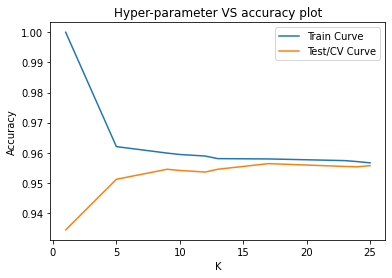

In [24]:
knn = KNeighborsClassifier()
a = 1
b = 25
folds = 20
train_scores, cv_scores, selected_k_list  = RandomSearchCV(X_train,y_train,knn, (a,b), folds)

plt.plot(selected_k_list,train_scores, label='Train Curve')
plt.plot(selected_k_list,cv_scores, label='Test/CV Curve')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title('Hyper-parameter VS accuracy plot')
plt.legend()
plt.show()

In [25]:
# understanding this code line by line is not that importent 
def plot_decision_boundary(X1, X2, y, clf):
        # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

Best value of K after intrepreting results of RandomSearchCV = 16

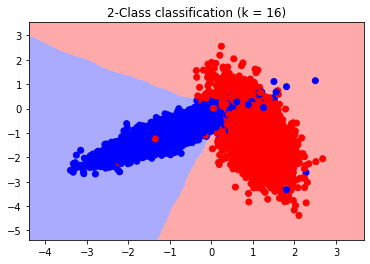

In [26]:
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors = 16)
neigh.fit(X_train, y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, neigh)

In [29]:
%%shell
jupyter nbconvert --to html "/content/Assignment_4_Random_Search_CV (1).ipynb"

[NbConvertApp] Converting notebook /content/Assignment_4_Random_Search_CV (1).ipynb to html
[NbConvertApp] Writing 386409 bytes to /content/Assignment_4_Random_Search_CV (1).html
